In [1]:
import urllib
from IPython.display import Markdown as md
_nb_loc = "06_preprocessing/06a_resizing.ipynb"
_nb_title = "크기 바꾸기를 위한 전처리"
_nb_message = ""

### no need to change any of this
_icons=["https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/ychoi-kr/practical-ml-vision-book-ko/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book-ko/blob/master/{0}".format(_nb_loc), "https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>AI Platform Notebook에서 실행</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Google Colab에서 실행</a></td><td><a target="_blank" href="{2}"><img src="{6}" />GitHub에서 소스 보기</a></td><td><a href="{3}"><img src="{7}" />노트북 내려받기</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=%ED%81%AC%EA%B8%B0+%EB%B0%94%EA%BE%B8%EA%B8%B0%EB%A5%BC+%EC%9C%84%ED%95%9C+%EC%A0%84%EC%B2%98%EB%A6%AC&download_url=https%3A%2F%2Fgithub.com%2Fychoi-kr%2Fpractical-ml-vision-book-ko%2Fraw%2Fmaster%2F06_preprocessing%2F06a_resizing.ipynb"><img src="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/logo-cloud.png"/>AI Platform Notebook에서 실행</a></td><td><a target="_blank" href="https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book-ko/blob/master/06_preprocessing/06a_resizing.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Google Colab에서 실행</a></td><td><a target="_blank" href="https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/06_preprocessing/06a_resizing.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />GitHub에서 소스 보기</a></td><td><a href="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/06_preprocessing/06a_resizing.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />노트북 내려받기</a></td></table><br/><br/><h1>크기 바꾸기를 위한 전처리</h1>

# 크기 바꾸기 및 전처리 레이어
이 노트북에서는 미리 훈련한(pre-trained) 이미지 임베딩을 써서 tf-flowers 데이터셋을 분류하는 신경망을 구축하는 방법을 보인다.

이 노트북은 [3장의 전이 학습 노트북](../03_image_models/03a_transfer_learning.ipynb)과 두 가지 주요한 차이가 있다.

* JPEG 파일이 아닌 TFRecord 파일을 읽음
* 이미지를 읽을 때가 아니라 모델에서 크기를 바꿈


## GPU 활성화 및 헬퍼 함수 셋업

이 저장소의 노트북들은 GPU를 사용하면 더 빨리 실행된다.

코랩에서:
- 수정 → 노트 설정 메뉴로 이동
- 하드웨어 가속기 드롭다운에서 GPU를 선택

Cloud AI Platform Notebooks에서:
- [https://console.cloud.google.com/ai-platform/notebooks](https://console.cloud.google.com/ai-platform/notebooks)로 이동
- GPU를 포함한 인스턴스를 생성하거나, 인스턴스를 선택하고 GPU를 추가

다음으로, 텐서플로로 GPU에 연결할 수 있는지 확인.

In [2]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.11.0
Found GPU at: /device:GPU:0


In [3]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

In [4]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
CLASS_NAMES = 'daisy dandelion roses sunflowers tulips'.split()

## TF Records 읽기

(240, 320, 3)
tf.Tensor(0.35263807, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(213, 320, 3)
tf.Tensor(0.69847864, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(240, 320, 3)
tf.Tensor(0.22729655, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(333, 500, 3)
tf.Tensor(0.2767833, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(240, 320, 3)
tf.Tensor(0.39305508, shape=(), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64)


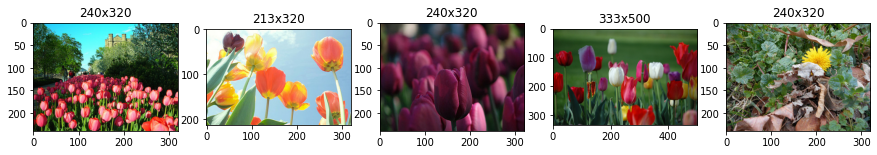

In [5]:
def parse_tfr(proto):
    feature_description = {
        'image': tf.io.VarLenFeature(tf.float32),
        'shape': tf.io.VarLenFeature(tf.int64),
        'label': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'label_int': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    }
    rec = tf.io.parse_single_example(
        proto, feature_description
    )
    shape = tf.sparse.to_dense(rec['shape'])
    img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)
    label_int = rec['label_int']
    return img, label_int

train_dataset = tf.data.TFRecordDataset(
    [filename for filename in tf.io.gfile.glob(
        'gs://practical-ml-vision-book/flowers_tfr/train-*')
    ], compression_type='GZIP').map(parse_tfr)

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(train_dataset.take(5)):
    print(img.shape)
    mean_of_image = tf.reduce_mean(img)
    print(mean_of_image)
    print(label_int)
    ax[idx].imshow((img.numpy()));
    ax[idx].set_title('{}x{}'.format(img.shape[0], img.shape[1]))

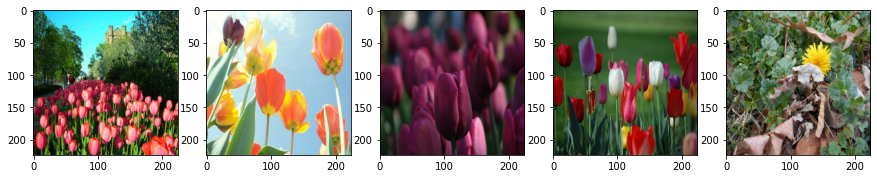

In [6]:
preproc_layers = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(
        height=IMG_HEIGHT, width=IMG_WIDTH,
        input_shape=(None, None, 3))
    ])

def apply_preproc(img, label):
    # add to a batch, call preproc, remove from batch
    x = tf.expand_dims(img, 0)
    x = preproc_layers(x)
    x = tf.squeeze(x, 0)
    return x, label

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(train_dataset.map(apply_preproc).take(5)):
    ax[idx].imshow((img.numpy()));

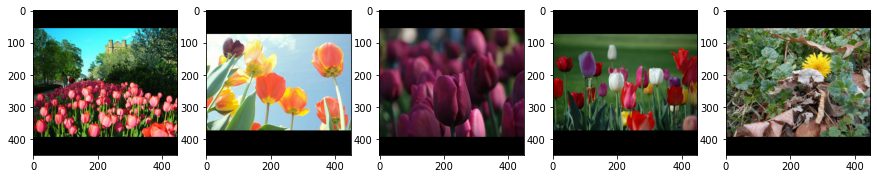

In [7]:
def apply_preproc(img, label):
    return tf.image.resize_with_pad(img, 2*IMG_HEIGHT, 2*IMG_WIDTH), label

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(train_dataset.map(apply_preproc).take(5)):
    ax[idx].imshow((img.numpy()));

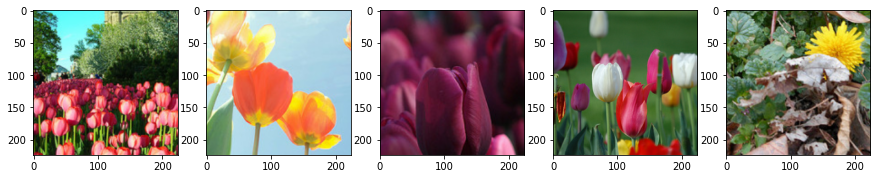

In [8]:
preproc_layers = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda img:
                           tf.image.resize_with_pad(
                               img, 2*IMG_HEIGHT, 2*IMG_WIDTH),
                           input_shape=(None, None, 3)),
    tf.keras.layers.experimental.preprocessing.CenterCrop(
        height=IMG_HEIGHT, width=IMG_WIDTH)
    ])

def apply_preproc(img, label):
    # add to a batch, call preproc, remove from batch
    x = tf.expand_dims(img, 0)
    x = preproc_layers(x)
    x = tf.squeeze(x, 0)
    return x, label

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(train_dataset.map(apply_preproc).take(5)):
    ax[idx].imshow((img.numpy()));

## MobileNet으로 전이 학습

사전 훈련 모델을 로드하고, Flattened 레이어 대신에 첫 번째 레이어로 사용해 보자.

In [9]:
import tensorflow_hub as hub
import os
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

preproc_layers = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda img:
                           tf.image.resize_with_pad(
                               img, 2*IMG_HEIGHT, 2*IMG_WIDTH),
                           input_shape=(None, None, 3)),
    tf.keras.layers.experimental.preprocessing.CenterCrop(
        height=IMG_HEIGHT, width=IMG_WIDTH)
    ])

def apply_preproc(img, label):
    # add to a batch, call preproc, remove from batch
    x = tf.expand_dims(img, 0)
    x = preproc_layers(x)
    x = tf.squeeze(x, 0)
    return x, label

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = tf.data.TFRecordDataset(
    [filename for filename in tf.io.gfile.glob(
        'gs://practical-ml-vision-book/flowers_tfr/train-*')
    ],
    compression_type='GZIP'
  ).map(parse_tfr).map(apply_preproc).batch(batch_size)

  eval_dataset = tf.data.TFRecordDataset(
    [filename for filename in tf.io.gfile.glob(
        'gs://practical-ml-vision-book/flowers_tfr/valid-*')
    ],
    compression_type='GZIP'
  ).map(parse_tfr).map(apply_preproc).batch(batch_size)

  layers = [
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  ]

  model = tf.keras.Sequential(layers, name='flower_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 dense_hidden (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 2,278,565
Trainable params: 20,581
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/10
92/92 [==============================] - 56s 484ms/step - loss: 0.7101 - accuracy: 0.7457 - val_loss: 0.4912 - val_accuracy: 0.8135
Epoch 2/10
92/92 [==============================] - 42s 452ms/step - loss: 0.323

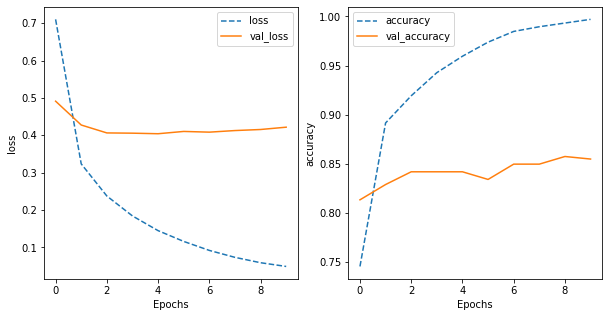

In [10]:
model = train_and_evaluate()

1/1 [==============================] - 0s 23ms/step


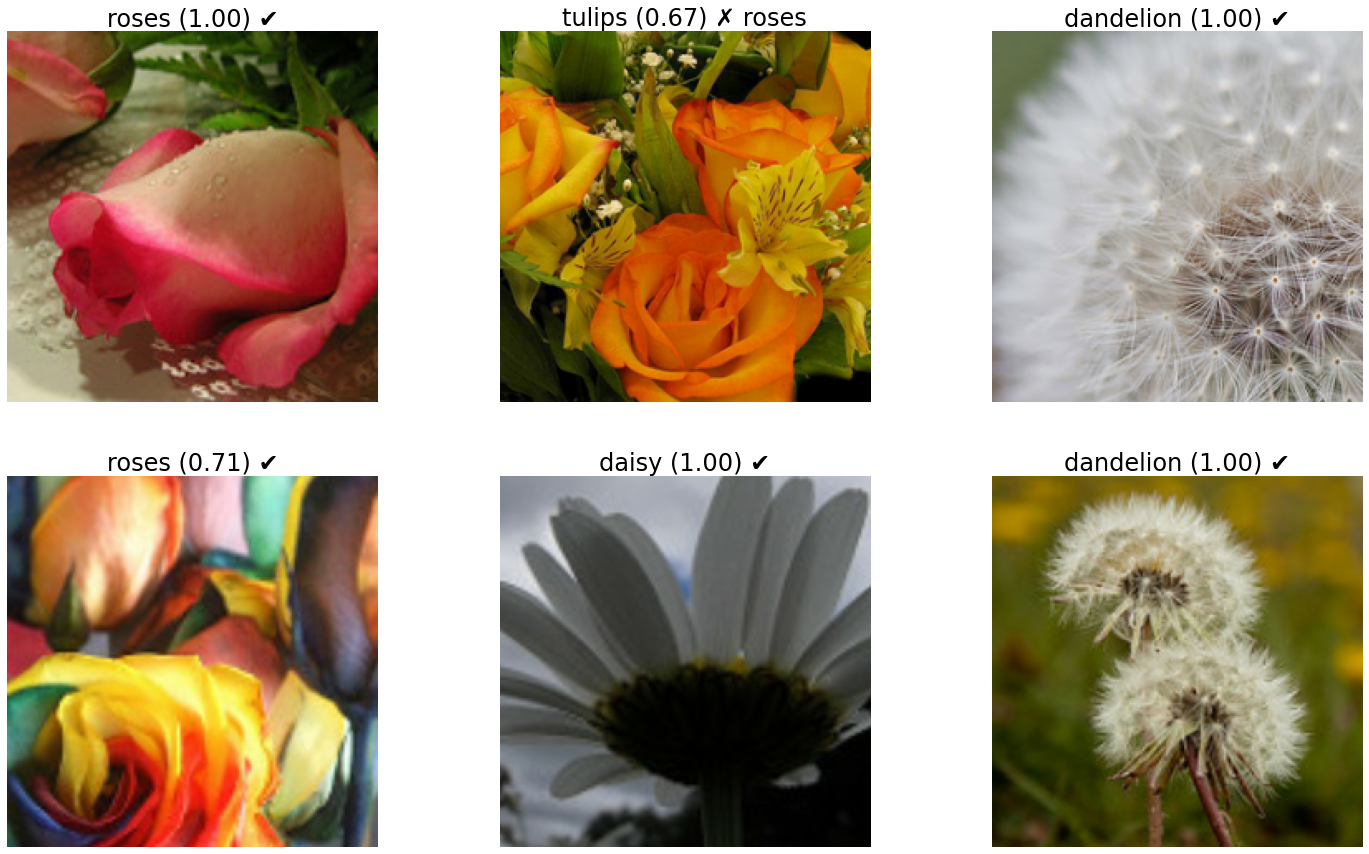

In [11]:
# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(model, pattern):
  dataset = tf.data.TFRecordDataset(
      [filename for filename in tf.io.gfile.glob(
        pattern)
      ],
      compression_type='GZIP'
  ).map(parse_tfr).map(apply_preproc).shuffle(100)

  nrows, ncols = 2, 3;
  f, ax = plt.subplots(nrows, ncols, figsize=(25,15))
  for idx, (img, label) in enumerate(dataset.take(6)):
    ax[idx//ncols, idx%ncols].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//ncols, idx%ncols].set_title('{} ({:.2f}) {}'.format( 
        pred_label, prob, 
        '\u2714' if (label == pred_label) else '\u2717 {}'.format(label)),
        fontsize=24)
    ax[idx//ncols, idx%ncols].axis('off')

plot_predictions(model, 'gs://practical-ml-vision-book/flowers_tfr/valid-*')

## 라이선스
Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.